Groep 02 <br>
Jolan Grégoire 202399739 <br>
Gemaakte analyses:
- Gemakkelijk 1
- Gemiddeld 3
- Gevorderd 1

In [1]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sqlalchemy import create_engine

# Gegevens voor de verbinding
server = "ARES"  # Servernaam of IP-adres van je SQL Server
database = "DEP1_DWH"  # Naam van je database

# Maak de verbindingsstring met Windows Authenticatie (Integrated Security)
engine = create_engine("mssql+pyodbc://@{}/{}?driver=ODBC+Driver+17+for+SQL+Server".format(server, database))

<h3>Gemakkelijk 1</h3>

DEEL 1

-- Stap 1: Voeg de kolom toe aan DimUser

``` sql
ALTER TABLE DimUser 
ADD UserType VARCHAR(100);
```

-- Stap 2: Update de kolom met de juiste waarden <br>

``` sql
UPDATE DimUser
SET UserType = 
    CASE 
        WHEN PVInstallationIndicator = 1 AND ElectricVehicleIndicator = 0 AND HeatPumpIndicator = 0 
        THEN 'Met zonnepanelen'
        WHEN PVInstallationIndicator = 0 AND ElectricVehicleIndicator = 0 AND HeatPumpIndicator = 0 
        THEN 'Zonder zonnepanelen'
        WHEN PVInstallationIndicator = 1 AND ElectricVehicleIndicator = 0 AND HeatPumpIndicator = 1 
        THEN 'Met warmtepomp en met zonnepanelen'
        WHEN PVInstallationIndicator = 1 AND ElectricVehicleIndicator = 1 AND HeatPumpIndicator = 0 
        THEN 'Met zonnepanelen en een thuisopladend elektrisch voertuig'
        WHEN PVInstallationIndicator = 0 AND ElectricVehicleIndicator = 1 AND HeatPumpIndicator = 0 
        THEN 'Zonder zonnepanelen en met een thuisopladend elektrisch voertuig'
    END;
```

controle:
``` sql
SELECT UserType, COUNT(*) 
FROM DimUser 
GROUP BY UserType;
```

In [3]:
sql = "SELECT UserType, COUNT(UserKey) AS NumberOfUsers FROM DimUser GROUP BY UserType"
df = pd.read_sql(sql, con=engine)
df.head()

,UserType,NumberOfUsers
0,Met zonnepanelen,300
1,Met warmtepomp en met zonnepanelen,300
2,Met zonnepanelen en een thuisopladend elektris...,300
3,Zonder zonnepanelen,300
4,Zonder zonnepanelen en met een thuisopladend e...,100


<Axes: xlabel='UserType', ylabel='NumberOfUsers'>

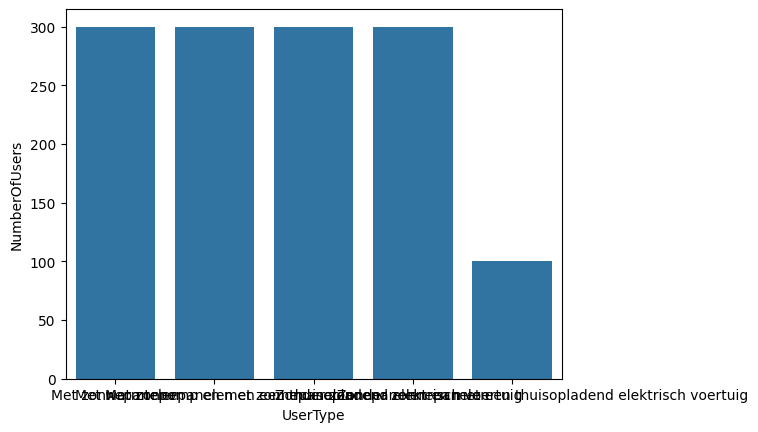

In [4]:
sns.barplot(x="UserType", y="NumberOfUsers", data=df)

DEEL 2

``` sql
CREATE TABLE DEP1_DWH.FactTable (
    UserKey INT NOT NULL,
    Year INT NOT NULL,
    Month INT NOT NULL,
    StartDateKey INT NOT NULL,
    StartDate DATE NOT NULL,
    MonthVolumeUsage DECIMAL(18,6) NOT NULL,
    MonthVolumeInjection DECIMAL(18,6) NOT NULL,
    MonthPeak DECIMAL(18,6) NOT NULL,
    MonthVolumeUsageDay DECIMAL(18,6) NOT NULL,
    MonthVolumeInjectionDay DECIMAL(18,6) NOT NULL,
    MonthVolumeUsageNight DECIMAL(18,6) NOT NULL,
    MonthVolumeInjectionNight DECIMAL(18,6) NOT NULL,
    PRIMARY KEY (Month)
);
```

<h3>Gemiddeld 3</h3>

In [5]:
query = '''
SELECT fe.DateKey, fe.ConsumptionVolume_kWh
FROM FactEnergyUsage fe
JOIN DimUser u ON fe.UserKey = u.UserKey
WHERE u.UserType = 'Zonder zonnepanelen'
'''
#AND fe.DateKey BETWEEN 20240101 AND 20241231

df = pd.read_sql(query, con=engine)

df['DateKey'] = pd.to_datetime(df['DateKey'], format='%Y%m%d')
df['Month'] = df['DateKey'].dt.month

season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

df['Season'] = df['Month'].map(season_mapping)
seasonal_consumption = df.groupby('Season')['ConsumptionVolume_kWh'].sum().reset_index()

print(seasonal_consumption)

   Season  ConsumptionVolume_kWh
0  Autumn              332355.14
1  Spring              313286.24
2  Summer              253664.81
3  Winter              505424.84


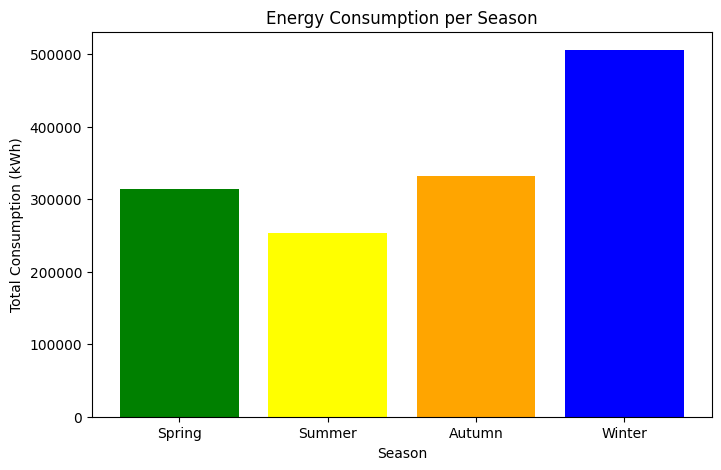

   Season  ConsumptionVolume_kWh
1  Spring              313286.24
2  Summer              253664.81
0  Autumn              332355.14
3  Winter              505424.84


In [6]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
seasonal_consumption['Season'] = pd.Categorical(seasonal_consumption['Season'], categories=season_order, ordered=True)
seasonal_consumption = seasonal_consumption.sort_values('Season')

# Barplot maken
plt.figure(figsize=(8, 5))
plt.bar(seasonal_consumption['Season'], seasonal_consumption['ConsumptionVolume_kWh'], color=['green', 'yellow', 'orange', 'blue'])
plt.xlabel('Season')
plt.ylabel('Total Consumption (kWh)')
plt.title('Energy Consumption per Season')
plt.show()

print(seasonal_consumption)

<h3>Gevorderd 1</h3>

Voorlopig een extra user want weet niet of wij iets hebben van piekvermogen in dwh.

In [7]:
# Bestanden inlezen met puntkomma als delimiter
df1 = pd.read_csv("..\data\input\Sprint2\Historiek_piekvermogen_elektriciteit_1301_20240201_20250331.csv", delimiter=";")
df2 = pd.read_csv("..\data\input\Sprint2\Historiek_piekvermogen_elektriciteit_1302_20250101_20250228.csv", delimiter=";")
df3 = pd.read_csv("..\data\input\Sprint2\Historiek_piekvermogen_elektriciteit_1303_20210901_20250228.csv", delimiter=";")

# Dataframes samenvoegen (onder elkaar stapelen)
df = pd.concat([df1, df2, df3], ignore_index=True)

# De eerste paar rijen bekijken
print(df.head())

  Van (datum) Van (tijdstip) Tot (datum) Tot (tijdstip)  EAN-code  Meter  \
0  01-02-2024       00:00:00  01-03-2024       00:00:00      1301    NaN   
1  01-03-2024       00:00:00  01-04-2024       00:00:00      1301    NaN   
2  01-04-2024       00:00:00  01-05-2024       00:00:00      1301    NaN   
3  01-05-2024       00:00:00  01-06-2024       00:00:00      1301    NaN   
4  01-06-2024       00:00:00  01-07-2024       00:00:00      1301    NaN   

        Metertype      Register Volume Eenheid Validatiestatus Omschrijving  
0  Digitale meter  Piekvermogen  4,349      kW      Uitgelezen          NaN  
1  Digitale meter  Piekvermogen  3,950      kW      Uitgelezen          NaN  
2  Digitale meter  Piekvermogen  9,308      kW      Uitgelezen          NaN  
3  Digitale meter  Piekvermogen  3,532      kW      Uitgelezen          NaN  
4  Digitale meter  Piekvermogen  4,456      kW      Uitgelezen          NaN  


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\jolan\AppData\Local\Temp\ipykernel_41156\3002670276.py:2: SyntaxWarning: invalid escape sequence '\d'
  df1 = pd.read_csv("..\data\input\Sprint2\Historiek_piekvermogen_elektriciteit_1301_20240201_20250331.csv", delimiter=";")
C:\Users\jolan\AppData\Local\Temp\ipykernel_41156\3002670276.py:3: SyntaxWarning: invalid escape sequence '\d'
  df2 = pd.read_csv("..\data\input\Sprint2\Historiek_piekvermogen_elektriciteit_1302_20250101_20250228.csv", delimiter=";")
C:\Users\jolan\AppData\Local\Temp\ipykernel_41156\3002670276.py:4: SyntaxWarning: invalid escape sequence '\d'
  df3 = pd.read_csv("..\data\input\Sprint2\Historiek_piekvermogen_elektriciteit_1303_20210901_20250228.csv", delimiter=

Dataframe opschonen om enkel de kolommen te behouden die nodig zijn voor de analyse

In [8]:
# Converteren van 'Volume' naar numeriek formaat (komma vervangen door punt)
df["Volume"] = df["Volume"].str.replace(",", ".").astype(float)

# Converteren van 'Van (datum)' naar datetime-formaat en jaar/maand extraheren
df["Van (datum)"] = pd.to_datetime(df["Van (datum)"], format="%d-%m-%Y")
df["Jaar"] = df["Van (datum)"].dt.year
df["Maand"] = df["Van (datum)"].dt.month

# Selecteren van relevante kolommen
df = df[["EAN-code", "Jaar", "Maand", "Volume"]]
df.rename(columns={"EAN-code": "UserKey", "Volume": "MonthPeek"}, inplace=True)

# Gecontroleerde dataset bekijken
print(df.head())


   UserKey  Jaar  Maand  MonthPeek
0     1301  2024      2      4.349
1     1301  2024      3      3.950
2     1301  2024      4      9.308
3     1301  2024      5      3.532
4     1301  2024      6      4.456


Waarschijnlijk wordt de factuurpiek berekend als een gemiddelde of een gewogen waarde van eerdere maandpieken.
Een standaard aanpak is de gemiddelde maandpiek van de afgelopen 12 maanden.

In [9]:
# Berekening van de factuurpiek als het gemiddelde van de laatste 12 maanden
df["FactuurPiek"] = df.groupby("UserKey")["MonthPeek"].rolling(window=12, min_periods=1).mean().reset_index(0, drop=True)

# Bekijken van de eerste rijen
print(df.head(15))


    UserKey  Jaar  Maand  MonthPeek  FactuurPiek
0      1301  2024      2      4.349     4.349000
1      1301  2024      3      3.950     4.149500
2      1301  2024      4      9.308     5.869000
3      1301  2024      5      3.532     5.284750
4      1301  2024      6      4.456     5.119000
5      1301  2024      7      4.402     4.999500
6      1301  2024      8      3.256     4.750429
7      1301  2024      9      4.241     4.686750
8      1301  2024     10      3.054     4.505333
9      1301  2024     11      3.622     4.417000
10     1301  2024     12      6.706     4.625091
11     1301  2025      1      3.977     4.571083
12     1301  2025      2      3.838     4.528500
13     1301  2025      3      0.000     4.199333
14     1302  2025      1      7.332     7.332000


alles samen in een functie die per maand de factuurpiek berekent voor alle gebruikers

In [ ]:
def bereken_factuurpiek(data):
    """
    Bereken de factuurpiek per gebruiker per maand op basis van maandpieken.
    
    Parameters:
        data (DataFrame): Een DataFrame met de kolommen 'UserKey', 'Jaar', 'Maand' en 'MonthPeek'.
    
    Returns:
        DataFrame: Het oorspronkelijke DataFrame met een extra kolom 'FactuurPiek'.
    """
    # Sorteren op UserKey, Jaar en Maand
    data = data.sort_values(by=["UserKey", "Jaar", "Maand"])

    # Berekening van de factuurpiek als gemiddelde van de laatste 12 maanden
    data["FactuurPiek"] = data.groupby("UserKey")["MonthPeek"].rolling(window=12, min_periods=1).mean().reset_index(0, drop=True)

    return data

# Functie toepassen
df_factuurpiek = bereken_factuurpiek(df)

# Bekijk de eerste resultaten
print(df_factuurpiek.head(15))


Toepassen op gebruiker 1303 (April 2024)

In [10]:
# Filteren op gebruiker 1303
#df_1303 = df_factuurpiek[df_factuurpiek["UserKey"] == 1303]
df_1303 = df[df["UserKey"] == 1303]

# Factuurpiek van april 2024 ophalen
factuurpiek_april_2024 = df_1303[(df_1303["Jaar"] == 2024) & (df_1303["Maand"] == 4)]["FactuurPiek"]

# Resultaat tonen
print("Factuurpiek voor gebruiker 1303 in april 2024:", factuurpiek_april_2024.values)


Factuurpiek voor gebruiker 1303 in april 2024: [12.7985]
